# Machine Learning Operations (MLOps)
## From "mlflow_task.ipynb" February 26, 2025
(use tensor_requirements.txt)

i. First, one is in the notebook - ‘mlflow_task.ipynb’. Complete all the tasks in this
notebook.

In this exercise, do the following:
1. Load the dataset used in the time series example - Energy consumption data. You can find it in the notebook "TSA_Example" in Time Series folder in Moodle.
2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test
3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used
4. Turn on MLFlow UI and track your experiments

In [202]:
import kagglehub
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem

import time, subprocess 
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import IPython.display as display
from sklearn.metrics import mean_absolute_error, root_mean_squared_error


In [203]:
kagglehub.dataset_download("robikscube/hourly-energy-consumption")
file_path = "C:\\Users\\Hassan\\.cache\\kagglehub\\datasets\\robikscube\\hourly-energy-consumption\\versions\\3\\PJME_hourly.csv"
data = pd.read_csv(file_path)
data.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [204]:
def func(ts_df):
    #making sure its in datetime format
    ts_df['Datetime'] = pd.to_datetime(ts_df['Datetime'])

    #Setting and sorting by index - getting chronological data
    ts_df.set_index('Datetime', inplace=True)
    ts_df.sort_index(inplace=True)
    #removing duplicates my keeping the first in order of occurance
    ts_df = ts_df.groupby(ts_df.index).first()
    
    # Convert time series hourly frequency, find the missing timestamps, set to N/A and interpolate all N/A values.
    missing_timestamps = ts_df.index[ts_df.isna().any(axis=1)]
    ts_df = ts_df.reindex(missing_timestamps.union(ts_df.index))

    ts_df = ts_df.asfreq('h')
    ts_df = ts_df.interpolate(method='linear')
    # extracting specific components from the datetime index
    ts_df["hour"] = ts_df.index.hour
    ts_df["day"] = ts_df.index.day
    ts_df["month"] = ts_df.index.month
    ts_df["weekday"] = ts_df.index.weekday


    return ts_df


In [205]:
data = func(data)

In [206]:
data

,PJME_MW,hour,day,month,weekday
Datetime,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1
2002-01-01 02:00:00,29265.0,2,1,1,1
2002-01-01 03:00:00,28357.0,3,1,1,1
2002-01-01 04:00:00,27899.0,4,1,1,1
2002-01-01 05:00:00,28057.0,5,1,1,1
...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,2,8,3
2018-08-02 21:00:00,43256.0,21,2,8,3
2018-08-02 22:00:00,41552.0,22,2,8,3


# 2. Setup a nested MLFlow loop where different modelling experiments can be tracked and the use the dataset in point 1 to experiment and track models. You should do following combinations:
    1. At least 3 model types
    2. At least 3 different feature combinations
    3. At least 3 different options for 3 different hyperparameters
    4. At least 3 different time splits for train test

In [ ]:
# Regression task - picking LinaerSVR, SARIMA and Lasso
# Originally wanted ot pick Support Vector Regression, however per its documentation it noted this was time complexity was "more than quadratic" to that would've been a timesink.
# scikit-learn documentation suggested to go with LinearSVR. 
# LinearSVR should good for regression tasks, scales up with the number of samples especially well if you use a Nystroem transformer ontop of it.
# this requires scaling the data with StandardScaler per the documentations example (https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR)

# SARIMA is a Seasonal variant of the ARIMA (AutoRegressive Integrated Moving Average). I understand very litte about it other than it is good for capturing seasonal patterns.
# #read more about it, its actually pretty cool - it works with the variables you have, creates lagged variables and difference the data (compare it with itself one step prior).

#Lasso is Least Absolute Shrinkage and Selection Operator. Linear regression method that is good for large datasets with with many features. I dont expect this one do that well.

models = {
    "Sarima": SARIMAX,
    "LinearSVR": LinearSVR,
    "Lasso": Lasso
}


feature_combinations = [
    ["hour", "day", ],
    ["hour", "month"],
    ["hour", "weekday",]
]

hyperparams = {
    "max_depth": [5, 10, 15],
    "order": [(5, 1, 0), (5, 1, 1), (3, 1, 1)],  # 3 (p, d, q) combinations 
    #p = the autoregressive term in this case model will go 5 and 3 units of time back (lag)  
    #d = differencing the data, i.e make it stationary. One for linear trends, two for Quadratic trends - i dont entirely understand, so we will just use 1.
    #q = 0 means the model will not consider error residuals from previous time step. 1 means the model will consider them. I.e it will learn from previous errors.
    # This is called the Moving average component and is very cool.

    "seasonal_order": [(1, 1, 1, 24)],  # (P, D, Q, s) for SARIMAX
    #basically the same as the order, but for capturing seasonal patterns in the data. 
    # P = The model will consider the same value for the same hour for the previous day.
    # D = the model will try to remove seasonal trends by differencing the data from the same hour from the previous day.
    # Q = The model will consider the residual errors from the previous day, same timestep.
    # Since we have hourly data the s value should be set for 24 
    "n_components": [100,250,500]  # components for Nystroem transformer
}


# # creating training split by seasonal equinox/solsice
# seasons = {
#     'Spring': pd.Timestamp(year=data.index.year.min(), month=3, day=21),
#     'Summer': pd.Timestamp(year=data.index.year.min(), month=6, day=21),
#     'Fall': pd.Timestamp(year=data.index.year.min(), month=9, day=21),
#     'Winter': pd.Timestamp(year=data.index.year.min(), month=12, day=21)
# }
# split_points = [seasons[season] for season in seasons]

# train_data = data[data.index < split_points[0]]
# test_data = data[data.index >= split_points[0]]


window_size = 365  # e.g., one year of data
train_data = data.iloc[:window_size]
test_data = data.iloc[window_size:window_size*2]

X_train = train_data.drop(columns=['PJME_MW'])
y_train = train_data['PJME_MW']
X_test = test_data.drop(columns=['PJME_MW'])
y_test = test_data['PJME_MW']

y_train = pd.Series(y_train.values, index=y_train.index)
y_test = pd.Series(y_test.values, index=y_test.index)

In [217]:

def forecast_in_chunks(model, steps, chunk_size=1000):
    predictions = []
    # 1k timesteps are forecasted incrementally - so my 8gb laptop doesnt die.
    for start in range(0, steps, chunk_size):
        #ensuring we dont exceed the total steps avail
        end = min(start + chunk_size, steps)
        #performs prediction per chuck
        chunk_predictions = model.forecast(steps=end - start)
        #append forecaseted values to array
        predictions.extend(chunk_predictions)
    return predictions

# 3. For each option in the combination, you should calculate & log the following in MLFlow:
    1. RMSE
    2. MAE
    3. Plot of actual vs predicted for 1 month data
    4. Plot of actual vs predicted for 1 week of data
    5. All of the combination info in point 2, such as which model, what feature combindation, what hyperparameter, what train test split has been used

In [218]:
#Experiment start - naming experiment 
mlflow.set_experiment("MLFlow Experiment LinearSVR+Sarimax+Lasso")
results = []


for features in feature_combinations:
    for model_name, model_class in models.items():
            for max_depth in hyperparams["max_depth"]:
                for order in hyperparams.get("order", [(5, 1, 0)]):  # (p, d, q) for SARIMAX
                    for seasonal_order in hyperparams.get("seasonal_order", [(1, 1, 1, 24)]):  # (P, D, Q, s) for SARIMAX
                        for n_components in hyperparams.get("n_components"): # componets for nystroem transformer
                            with mlflow.start_run():
                                
                                #logs parameters
                                mlflow.log_param("features", features)
                                mlflow.log_param("model_type", model_name)
                                mlflow.log_param("max_depth", max_depth)
                                mlflow.log_param("n_components", n_components)
                                mlflow.log_param("order", order)
                                mlflow.log_param("seasonal_order", seasonal_order)
                                mlflow.log_param("train_test_split", "seasonal")

                                # modeltraining
                                if model_name == "Sarima":
                                    #fit Sarima
                                    model = SARIMAX(y_train, order=order, seasonal_order=seasonal_order)
                                    model_fit = model.fit(disp=False)                                
                                    
                                    predictions = forecast_in_chunks(model_fit, len(y_test))
                                elif model_name == "LinearSVR":    
                                    model = LinearSVR()    
                                    #scaling data #probs dont do this each loop
                                    scaler  = StandardScaler()
                                    X_train_scaled = scaler.fit_transform(X_train[features])
                                    X_test_scaled = scaler.fit_transform(X_test[features])
                                    # setting up the transformer layer
                                    ns_transformer = Nystroem(n_components=n_components, random_state=808)
                                    X_train_ns = ns_transformer.fit_transform(X_train_scaled)
                                    X_test_ns = ns_transformer.fit_transform(X_test_scaled)

                                    model.fit(X_train_ns, y_train)
                                    predictions = model.predict(X_test_ns) 


                                elif model_name == "Lasso":
                                    model = Lasso()
                                    model.fit(X_train[features], y_train)
                                    predictions = model.predict(X_test[features])


                                # Metrics
                                rmse = root_mean_squared_error(y_test, predictions)
                                mae = mean_absolute_error(y_test, predictions)
                                mlflow.log_metric("rmse", rmse)
                                mlflow.log_metric("mae", mae)
                                #Logging model
                                mlflow.sklearn.log_model(model, model_name)

                                # Store results for summary
                                results.append({
                                    "features": features,
                                    "model": model_name,
                                    "order": order,
                                    "seasonal_order": seasonal_order,
                                    "n_components": n_components,
                                    "rmse": rmse,
                                    "mae": mae
                                    })



2025/03/15 23:23:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/15 23:23:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/15 23:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
c:\Users\Hassan\miniconda3\envs\tensorvenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2025/03/15 23:23:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto 

# results

### 1st run
All right 54 models run! Below is the pipeline parallel cordinate plot from the my first run of the 3 methods, feature-combinations and hyperparams selected above.
Specfically what I had tried to do here was to have a seasonal data split to try to capture some patterns.  
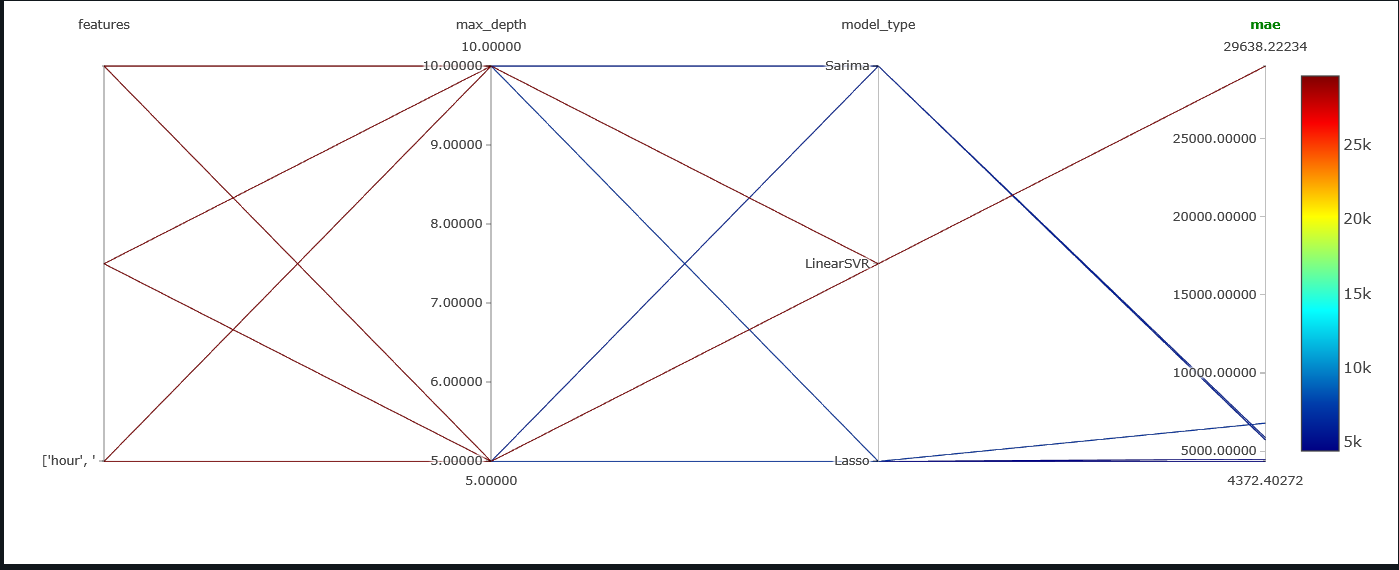

In this run, SARIMAX performed best with RMSE variying between between 6060 and 8784 and MAE between 4509 and 6817.
Lasso was second best around RMSE 5899 and MAE at 4372.
Worst of all, LinaerSVR provided reached 30336.6 in RSME and MAE of 29637.

### 2nd run
So next run I tried removed the seasonal split and went for a rolling one over a year instead.
pipeline parallel cordinate plot below:

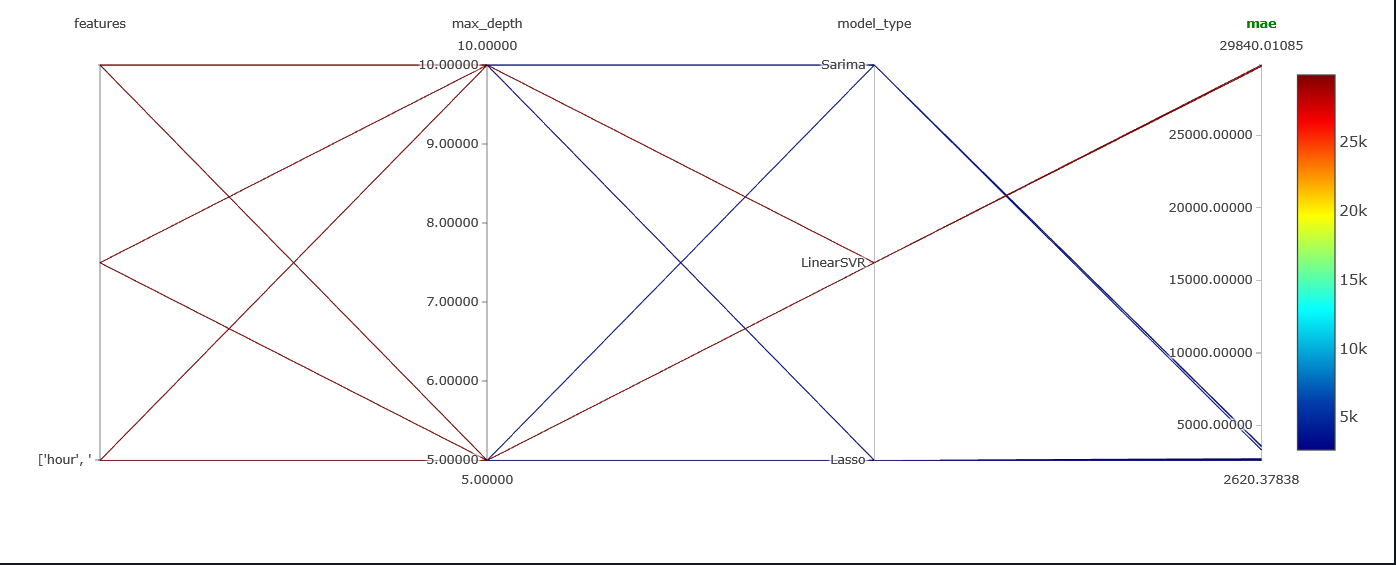


A clear improvement!
The winner here was Lasso! :
- RMSE: 3264.1
- MAE: 2620.4


Sarima: 
-    RMSE: 3309.6
-    MAE: 2691.2

LinearSVR's less so: 
- RMSE:  30085.9
- MAE:   29840


### 3rd run
I tried to add some more hyperparameters to see if I could change things for the Linear and Lasso:
n_components :[100] => n_components: [100,250,500] 
max_depth: [5, 10] =>  max_depth: [5, 10, 15]
did not realize how many more models this would make - 240 ones.
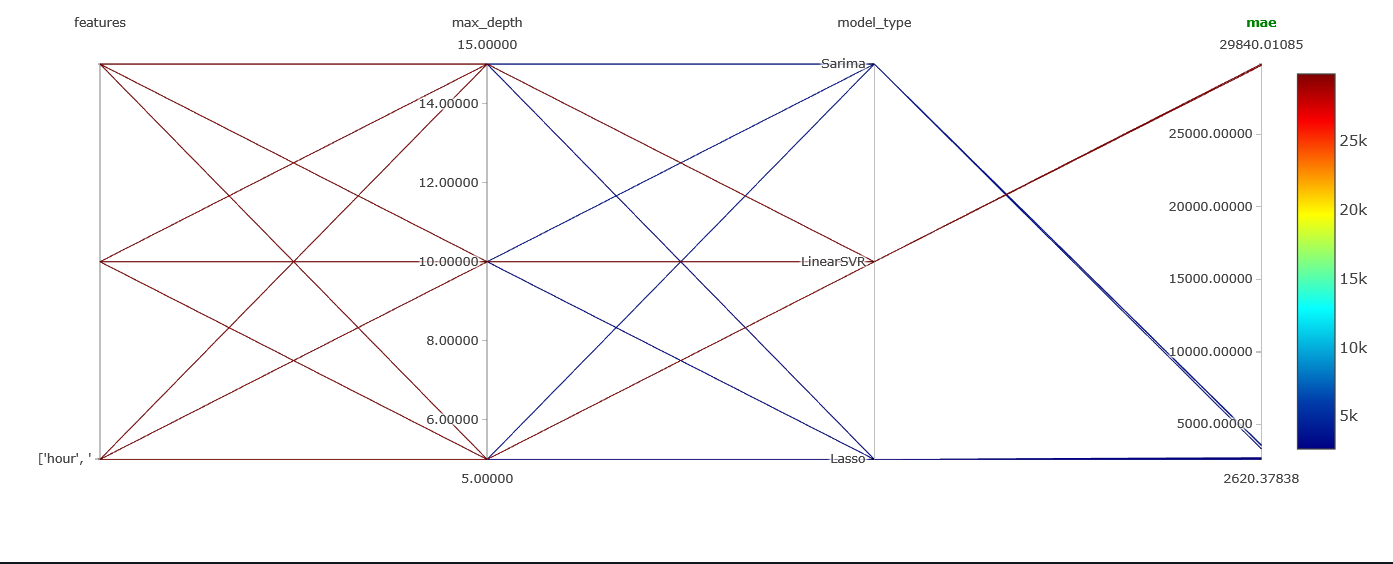


see below for summary

In [219]:
# This way you dont need access to my actual models, and can check the values for each last
# Print summary of results
results_df = pd.DataFrame(results)
print("\nSummary of Experiment Results:")
print(results_df)


Summary of Experiment Results:
            features   model      order seasonal_order  n_components  \
0        [hour, day]  Sarima  (5, 1, 0)  (1, 1, 1, 24)           100   
1        [hour, day]  Sarima  (5, 1, 0)  (1, 1, 1, 24)           250   
2        [hour, day]  Sarima  (5, 1, 0)  (1, 1, 1, 24)           500   
3        [hour, day]  Sarima  (5, 1, 1)  (1, 1, 1, 24)           100   
4        [hour, day]  Sarima  (5, 1, 1)  (1, 1, 1, 24)           250   
..               ...     ...        ...            ...           ...   
238  [hour, weekday]   Lasso  (5, 1, 1)  (1, 1, 1, 24)           250   
239  [hour, weekday]   Lasso  (5, 1, 1)  (1, 1, 1, 24)           500   
240  [hour, weekday]   Lasso  (3, 1, 1)  (1, 1, 1, 24)           100   
241  [hour, weekday]   Lasso  (3, 1, 1)  (1, 1, 1, 24)           250   
242  [hour, weekday]   Lasso  (3, 1, 1)  (1, 1, 1, 24)           500   

            rmse          mae  
0    4254.663014  3337.533418  
1    4254.663014  3337.533418  
2    42

In [228]:
best_models_mae = results_df.loc[results_df.groupby('model')['mae'].idxmin()].sort_values(by='mae')
best_models_mae

,features,model,order,seasonal_order,n_components,rmse,mae
216,"[hour, weekday]",Lasso,"(5, 1, 0)","(1, 1, 1, 24)",100,3264.067812,2620.378376
0,"[hour, day]",Sarima,"(5, 1, 0)","(1, 1, 1, 24)",100,4254.663014,3337.533418
110,"[hour, month]",LinearSVR,"(5, 1, 0)","(1, 1, 1, 24)",500,29996.047864,29750.080150


### conclusion
Based on the error metrics the Lasso model is the best-performing model among the three. This is very confounding as this was the one i put the least thought into.
Sarima, performs worse with higher errors compared to Lasso.
And finally we have LinearSVR model - What I am seeing with its consistency in performing poorly eitehr I am configuring it incorrectly, or it is simply not made for this type of dataset.

In [211]:
# Start MLFlow UI from the notebook
print("\nStarting MLFlow UI...")
process = subprocess.Popen(["mlflow", "ui", "--port", "5000"])  # Starts MLFlow UI on port 5000

# Wait a moment to ensure the server starts
time.sleep(3)

# Display a link to the MLFlow UI
display.display(display.Markdown("[Open MLFlow UI](http://localhost:5000)"))

print("MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.")


Starting MLFlow UI...


[Open MLFlow UI](http://localhost:5000)

MLFlow UI is running at http://localhost:5000. Press Ctrl+C in the terminal to stop it.
